# Simulated annealing proof of concept

In [42]:
# this imports the code written in the src directory
import sys
sys.path.insert(0, '../src/')

# imports the relevant custom code
from annealing import Annealer
from tours import KDroneTour

# some useful numpy stuff used here
from numpy.random import rand
from numpy import array

# plotting fun!
from matplotlib.pyplot import subplots
%matplotlib inline

Let $S = \{p_0, \dots, p_{n-1}\} \subseteq \mathbb{R}^2$ be a point set in the plane. A tour is simply an arbitrary sublist of the indices $\{0, \dots, n-1\}$ in arbitrary order. A $k$-tour is a list of $k$ such sublists with the property that each index in $\{0, \dots, n-1\}$ is represented in *exactly one* of the sublists.

An example of a 5-tour on a point set of 10 elements might be:

    [
        [1, 2, 8],
        [0],
        [3],
        [4, 9, 7],
        [6]
    ]
    
The cost associated with any tour is the sum of the distances between the points in the tour:

$$
    C(\mathit{tour}, S) = \sum_{t \in \mathit{tour}} \| p_t - p_{t-1} \|_2.
$$

(here $p_{n} = p_{0} $).

In [49]:
def plot_policies(tours, points, axis):
    """
    :param tours: a given k-tour of the point set
    :type tours: list[list]
    :param points: a two dimemnsional point set
    :type points: numpy.ndarray
    :param axis: the object that gets the plot drawn on it.
    :type axis: matplotlib.axes.Axes
    
    :return: n/a (called for side effects)
    :rtype: None
    
    Given a set of tours and a two dimensional point set, plot the points, and draw the tours.
    The axis that is specified is where the plot is actually drawn on.
    """
    # plot the point set
    axis.plot(*points.T, 'o')
    
    # label each point 0, ..., points.shape[0] - 1
    for i in range(points.shape[0]):
        axis.annotate(str(i), points[i])
        
    for tour in tours:
        # for each tour, draw a polygon on the relevant points
        axis.fill(*array([points[x] for x in tour]).T, fill=False)

We can randomly generate two-dimensional points in the unit square $[0,1] \times [0,1]$ by use of the `numpy.random.rand` call.

In [60]:
# generate a two dimensional point set, uniformly distributed on the box [0,1] x [0,1]
points = rand(20, 2)

As an example of how to use simulated annealing, we create a `KDroneTour` object from the generated point set and configure an `Annealer` object. From a random starting state, we perform simulated annealing until some kind of "convergence". We plot the result to show how it might work out here:

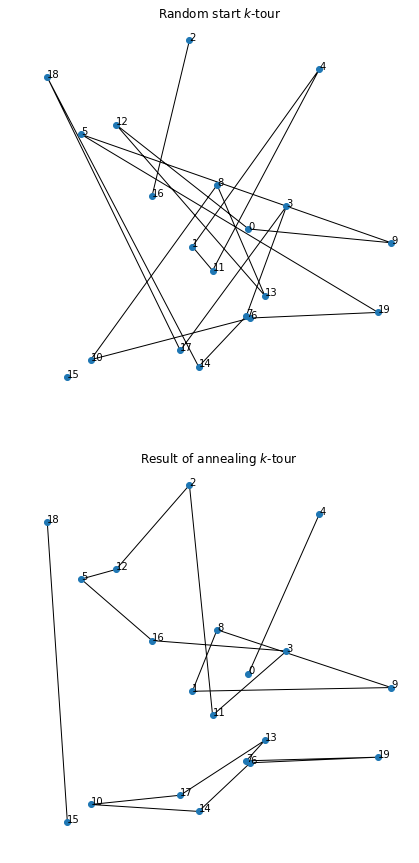

In [62]:
# set up the simulated annealing with a k-drone tour
ktour = KDroneTour(points, 5)
annealer = Annealer(ktour)
random_start = annealer.space.random_state()

# perform simulated annealing on the random starting k-tour and return the result.
annealed_tours, penalty = annealer.anneal(random_start);

# plot the results
fig, axes = subplots(2, 1, figsize=(15, 15))
plot_policies(random_start, points, axes[0])
plot_policies(annealed_tours, points, axes[1])
for ax in axes:
    ax.set_aspect('equal')
    ax.axis('off');
    
axes[0].set_title("Random start $k$-tour");
axes[1].set_title("Result of annealing $k$-tour");